# LOCATION EXTRACTION 

![Picture1.png](Picture1.png)

## Table of contents

- [Loading packages into the notebook](#Loading-required-packages)
- [Loading and exploring data](#Loading-and-exploring-data)
- [Data preprocessing and cleaning](#Data-cleaning-and-Preprocessing)
- [spaCy: Loading and exploring](#spaCy:-Loading-and-exploring)
- [Extracting location entities](#Extracting-location-entities)
- [Cleaning and combining locations](#Cleaning-and-combining-locations)
- [Geocoding with Nominatim](#Geocoding-with-Nominatim)
- [Visualising data](#Visualising-data)
- [Distance Calculations](#Distance-calculation)
- [Result visualisation](#Result-visualisation)
- [Assignment](#Assignment)
- [Improving results using keywords](#Grammatical-Filtering)

## Loading required packages 

In [1]:
import pandas as pd
import numpy as np
import sys, os

#pd.set_option('display.max_colwidth', None)

[Return to Table of Contents](#Table-of-contents)

## Loading and exploring data

In [2]:
# Loading data 
df = pd.read_csv('california_tweets.csv')

# shape of the data (rows, columns)
df.shape

(2000, 6)

In [3]:
# Visualising the first (number) rows within the dataset
df.head(5)

,Unnamed: 0,text,place,src_lang,long,lat
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,en,-122.500464,37.593650
1,1,_styledbym.e killed it with this #shadowroot #...,NaN,en,-121.989751,38.355840
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",en,-120.829960,37.774330
3,3,Warriors single game tickets go on sale at 10...,San Jose; CA,en,-121.891766,37.332484
4,4,I'm at Hardly Strictly Bluegrass in San Franc...,San Francisco; CA,en,-122.489542,37.771727


***

Our data is made up of 2000 rows and 5 columns. The text column contains tweet posts sent from different users. The data has been filtered to return only tweets with longitute and latitude values which will be used later on to verify the accuracy of the location extraction. 

***

[Return to Table of Contents](#Table-of-contents)

## Data cleaning and Preprocessing 

Given the noice in the tweet texts, we clean up our tweets before applying NLP. 

- Return only english tweets 
- Remove special characters
- Replace @ with at 
- Remove resulting empty cells 

In [4]:
# Only english tweets 
df['text_en'] = df.text
is_english = df.src_lang == 'en'
df.loc[is_english, 'text_en'] = df.loc[is_english, 'text']
df = df.loc[is_english]

In [5]:
# Remove special characters
def preprocess_tweets(tweets, remove_tokens = ('\n', '\r', '\t', 'RT', r'[^\x00-\x7f]'),
                meta_information_indicators = ('https:', 'http:', 'www.', '//t.co'),
                allowed_punctuation = (',', '.', '.', '!', '?', ' ', ':', '-', ';','@')):
    def keep_token(token):
        return token not in remove_tokens and\
        not any(token.startswith(meta_token) for meta_token in meta_information_indicators)
    
    clean_tweets = tweets.apply(lambda x: ' '.join(filter(keep_token, x.split(' '))))
    
    keep_char = lambda t: t.isalnum() or t in allowed_punctuation
    return clean_tweets.apply(lambda x: ''.join(filter(keep_char, list(x))))
    
clean_tweets = preprocess_tweets(df.text_en)
df['clean_text'] = clean_tweets

In [6]:
# use np.nan for all missing values
df = df.replace('-', np.nan).fillna(np.nan)

# remove empty columns
df = df.dropna(how='all', axis='columns')

# remove rows without text
df = df.dropna(subset=['text'])

#Replace @ with at for spaCy syntax 
df.clean_text = df.clean_text.str.replace("@", "at ")

In [7]:
df.head(3)

,Unnamed: 0,text,place,src_lang,long,lat,text_en,clean_text
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,en,-122.500464,37.59365,"I'm at My Home Gym in Pacifica, CA https://t....","Im at My Home Gym in Pacifica, CA"
1,1,_styledbym.e killed it with this #shadowroot #...,NaN,en,-121.989751,38.35584,_styledbym.e killed it with this #shadowroot #...,styledbym.e killed it with this shadowroot col...
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",en,-120.829960,37.77433,Primigi Classic loafers for your boy or girl. ...,Primigi Classic loafers for your boy or girl. ...


In [8]:
# Dropping some columns to reduce data size to necessary columns 

# Make sure to only run this cell once as a duplicate returns error of cells not found
df = df.drop(['Unnamed: 0', 'src_lang', 'text_en'], axis = 1 )
df.head(3)

,text,place,long,lat,clean_text
0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.59365,"Im at My Home Gym in Pacifica, CA"
1,_styledbym.e killed it with this #shadowroot #...,NaN,-121.989751,38.35584,styledbym.e killed it with this shadowroot col...
2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.77433,Primigi Classic loafers for your boy or girl. ...


**Exercise**

> What other preprocessing routines could be done or what preprocessing steps could be left out

[Return to Table of Contents](#Table-of-contents)

## spaCy: Loading and exploring

[spaCy](https://spacy.io/) is a NLP tool developed by Explosion to extract entities in text. Unlike most NLP packages that rely on a Gazetteer to extract locations, spaCy uses sentence structure to determine the entity of a word. The **advantage** of this approach is that it is able to return locations even with spelling errors. **Disadvantage** is possible false positives due to different sentence syntaxes. 

In [9]:
# Loading spaCy packages 
import spacy
from spacy import displacy # Displacy is used to visualise spaCy tokens

In [10]:
# Loading the spaCy model 
nlp =spacy.load('en_core_web_trf') # model trf higher accuracy, bigger model, slower in exercution

****
Before extracting locations within the dataset, we can first play around with self made example sentences to explore how spaCy works. You can rewrite your own sentences and explore what kind of results spaCy would return.

****

In [11]:
# Example sentences 

doc = nlp("""Hello Everyone, welcome to the 2021 summer siemester Spring School.
        The spring school is presented by the University of Salzburg in Salzburg, Austria
        Did you know, Micheal Jackson's jacket was valued at 10billion dollars?
        I first have to Google why Google has so may employees.
        Zara and I are doing some shopping in Ikea after which we visit the Hellbrun Palace""")

In [12]:
# Visualising spaCy entities
displacy.render(doc, style = "ent")

In [13]:
# spacy.explain is used to define the entities returned by spaCy
spacy.explain("FAC")

'Buildings, airports, highways, bridges, etc.'

**Exercise**

>Experiment with spaCy writing different sentence structures. Show instances where spaCy wrongly detects an entity or omits an entity.

[Return to Table of Contents](#Table-of-contents)

## Extracting location entities 

In [14]:
# Function to get location information 
def filter_location_entities(entities):
    locations = []
    for entity in entities:
        if entity.label_ == 'GPE':
                locations.append(entity)
                
    return locations

def filter_location_entities1(entities):
    locations1 = []
    for entity in entities:
        if entity.label_ == 'FAC':
                locations1.append(entity)
                      
    return locations1

def filter_location_entities2(entities):
    locations2 = []
    for entity in entities:
        if entity.label_ == 'ORG':
                locations2.append(entity)
                      
    return locations2

def filter_location_entities3(entities):
    locations3 = []
    for entity in entities:
        if entity.label_ == 'LOC':
                locations3.append(entity)
                      
    return locations3

In [15]:
#creates a new column, ner_text, with entities extracted from a column titled 'text'
df['GPE'] = df['clean_text'].astype(str).apply(lambda x: filter_location_entities(nlp(x).ents))
df['FAC'] = df['clean_text'].astype(str).apply(lambda x: filter_location_entities1(nlp(x).ents))
df['ORG'] = df['clean_text'].astype(str).apply(lambda x: filter_location_entities2(nlp(x).ents))
df['LOC'] = df['clean_text'].astype(str).apply(lambda x: filter_location_entities3(nlp(x).ents))
df

,text,place,long,lat,clean_text,GPE,FAC,ORG,LOC
0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.593650,"Im at My Home Gym in Pacifica, CA","[(Pacifica), (CA)]",[],[],[]
1,_styledbym.e killed it with this #shadowroot #...,NaN,-121.989751,38.355840,styledbym.e killed it with this shadowroot col...,[],[],[],[]
2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.774330,Primigi Classic loafers for your boy or girl. ...,[],[],[(Primigi)],[]
3,Warriors single game tickets go on sale at 10...,San Jose; CA,-121.891766,37.332484,Warriors single game tickets go on sale at 10...,[],[],[],[]
4,I'm at Hardly Strictly Bluegrass in San Franc...,San Francisco; CA,-122.489542,37.771727,Im at Hardly Strictly Bluegrass in San Franci...,"[(San, Francisco), (CA)]",[],[],[]
...,...,...,...,...,...,...,...,...,...
1995,how do i change the font on my phone 😐,6fafb06c49df870f,-122.264870,37.998157,how do i change the font on my phone,[],[],[],[]
1996,@Vanessaah_x I just ran out lol,ee2cfc9feb061a08,-120.845655,37.504062,at Vanessaahx I just ran out lol,[],[],[],[]
1997,@muhbellsaywhaat loves me. I know she do.,8004d2bebcc13e8c,-122.039433,37.971872,at muhbellsaywhaat loves me. I know she do.,[],[],[],[]
1998,#ElvistheCorgi #SamtheCorgi #GigitheFrenchie #...,NaN,-122.894090,38.479099,ElvistheCorgi SamtheCorgi GigitheFrenchie dog ...,[],[],[],[]


****
Because of the time taken in extracting location entities from the dataframe. It is advisible to save the file locally within within your PC incase the notebook fails then you dont have to rerun the extraction process again. 
****

In [16]:
#Saving dataframe with extracted location entities 
outfilename = ('df_location_entities1.csv')
df.to_csv(outfilename)

[Return to Table of Contents](#Table-of-contents)

## Cleaning and combining locations 

In [17]:
df = pd.read_csv('df_location_entities1.csv')
df.head(3)

,Unnamed: 0,text,place,long,lat,clean_text,GPE,FAC,ORG,LOC
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.59365,"Im at My Home Gym in Pacifica, CA","[Pacifica, CA]",[],[],[]
1,1,_styledbym.e killed it with this #shadowroot #...,NaN,-121.989751,38.35584,styledbym.e killed it with this shadowroot col...,[],[],[],[]
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.77433,Primigi Classic loafers for your boy or girl. ...,[],[],[Primigi],[]


In [18]:
df.shape

(1902, 10)

In [19]:
# Remove square brakets from location
df['GPE'] =  df['GPE'].apply(lambda x: x.replace('[','').replace(']',''))
df['FAC'] =  df['FAC'].apply(lambda x: x.replace('[','').replace(']',''))
df['ORG'] =  df['ORG'].apply(lambda x: x.replace('[','').replace(']',''))
df['LOC'] =  df['LOC'].apply(lambda x: x.replace('[','').replace(']',''))

df.head(4)

,Unnamed: 0,text,place,long,lat,clean_text,GPE,FAC,ORG,LOC
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.593650,"Im at My Home Gym in Pacifica, CA","Pacifica, CA",,,
1,1,_styledbym.e killed it with this #shadowroot #...,NaN,-121.989751,38.355840,styledbym.e killed it with this shadowroot col...,,,,
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.774330,Primigi Classic loafers for your boy or girl. ...,,,Primigi,
3,3,Warriors single game tickets go on sale at 10...,San Jose; CA,-121.891766,37.332484,Warriors single game tickets go on sale at 10...,,,,


In [20]:
#Droping rows without location entity extracted
# Only drops rows where all conditions are met that is all four entities do not have location.

index_names = df[(df['GPE']== '') & (df['FAC']== '') & (df['ORG']== '') & (df['LOC']== '')].index
df.drop(index_names, inplace = True)
df.head(4)

,Unnamed: 0,text,place,long,lat,clean_text,GPE,FAC,ORG,LOC
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.593650,"Im at My Home Gym in Pacifica, CA","Pacifica, CA",,,
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.774330,Primigi Classic loafers for your boy or girl. ...,,,Primigi,
4,4,I'm at Hardly Strictly Bluegrass in San Franc...,San Francisco; CA,-122.489542,37.771727,Im at Hardly Strictly Bluegrass in San Franci...,"San Francisco, CA",,,
9,10,"Forgotten, on a side walk. Understood. @ Weste...",NaN,-122.428000,37.782500,"Forgotten, on a side walk. Understood. at Wes...",San Francisco,Western Addition,,


In [21]:
df.shape

(668, 10)

**Combine only when second column is not null**

In [22]:
# Combining location entities 
df['FAC_GPE']= df['FAC'].str.cat(df['GPE'], sep = " ")
df['ORG_GPE']= df['ORG'].str.cat(df['GPE'], sep = " ")
df['LOC_GPE']= df['LOC'].str.cat(df['GPE'], sep = " ")
df

,Unnamed: 0,text,place,long,lat,clean_text,GPE,FAC,ORG,LOC,FAC_GPE,ORG_GPE,LOC_GPE
0,0,"I'm at My Home Gym in Pacifica, CA https://t....",Pacifica; CA,-122.500464,37.593650,"Im at My Home Gym in Pacifica, CA","Pacifica, CA",,,,"Pacifica, CA","Pacifica, CA","Pacifica, CA"
2,2,Primigi Classic loafers for your boy or girl. ...,"East Oakdale, CA",-120.829960,37.774330,Primigi Classic loafers for your boy or girl. ...,,,Primigi,,,Primigi,
4,4,I'm at Hardly Strictly Bluegrass in San Franc...,San Francisco; CA,-122.489542,37.771727,Im at Hardly Strictly Bluegrass in San Franci...,"San Francisco, CA",,,,"San Francisco, CA","San Francisco, CA","San Francisco, CA"
9,10,"Forgotten, on a side walk. Understood. @ Weste...",NaN,-122.428000,37.782500,"Forgotten, on a side walk. Understood. at Wes...",San Francisco,Western Addition,,,Western Addition San Francisco,San Francisco,San Francisco
10,11,@StarlineSC #lightshow @ Starline Social Club ...,NaN,-122.272507,37.812812,at StarlineSC lightshow at Starline Social Club,,,Starline Social Club,,,Starline Social Club,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1885,1982,#sunrise #pier14 #sanfrancisco #ca @ Pier 14 ...,South Beach; San Francisco,-122.389897,37.794424,sunrise pier14 sanfrancisco ca at Pier 14 Em...,"San Francisco, California",Pier 14 Embarcadero,,,"Pier 14 Embarcadero San Francisco, California","San Francisco, California","San Francisco, California"
1893,1991,Drinking an IPA by @lagunitasbeer @ Craig Mart...,"Pittsburg, CA",-121.884000,38.001300,Drinking an IPA by at lagunitasbeer at Craig ...,,,Craig Martin Home Brews,,,Craig Martin Home Brews,
1894,1992,Warriors win 😀 @ Oracle Arena and Oakland Alam...,"Oakland, CA",-122.202223,37.750748,Warriors win at Oracle Arena and Oakland Ala...,,"Oracle Arena, Oakland Alameda County Coliseum",,,"Oracle Arena, Oakland Alameda County Coliseum",,
1896,1994,@SanJoseSharks WIN 3-2 IN OT #SJSharks https:...,San Jose; CA,-121.900758,37.332135,at SanJoseSharks WIN 3-2 IN OT SJSharks,,,"SanJoseSharks, SJSharks",,,"SanJoseSharks, SJSharks",


****
We combine location entities in a manner that resembles actual addresses starting with a finer place name example **Building name: Stein Hotel** to a more course place reference **city name: Salzburg** to an even coarser place name e.g **Country: Austria**
****

**Exercise**

Can you argue for any other way to combine the locations apart from the ones already implemented? 

[Return to Table of Contents](#Table-of-contents)

# Geocoding with Nominatim 

In [23]:
# Loading required packages for geocoding with Nominatim
import geopandas as gpd 
import geopy
import matplotlib.pyplot as plt
from functools import partial 
from geopy import distance
from geopy.distance import geodesic
from tqdm import tqdm, tqdm_notebook # progress bar

#initiate 
tqdm.pandas()

In [24]:
# user_agent is used to overide restricts of using Nominatim default user_agent.
locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')

In [25]:
# Set to avoid the error of 'Too many requests 429 error'
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

# return locations in english 
geocode = partial(locator.geocode, language = "en")

****
[Nominatim](https://nominatim.org/release-docs/latest/) has a limit of 1 request per second which translates to 86 400 requests per day without retrying. Depending on the number of retries Nominatim does on a certain address, the final returned results on a single day will be lower than 86 400. Nominatim blocks users from sending multiple requests of the same location. To reduce geocoding time and avoid being blocked, we geocode only the unique locations and map results to requested locations. 
****

In [26]:
#Count unique locations in column FAC_GPE
df['FAC_GPE'].nunique()

332

In [30]:
unique_FAC_GPE = df.groupby('FAC_GPE')['Unnamed: 0'].unique()
outfilename = ('unique_FAC_GPE.csv')
unique_FAC_GPE.to_csv(outfilename)

In [31]:
df1 = pd.read_csv('unique_FAC_GPE.csv')
df1

,FAC_GPE,Unnamed: 0
0,,[ 2 11 51 52 65 103 105 129 156 ...
1,"Alameda, CA",[436 565]
2,"Alameda, California",[741]
3,"Albany, CA",[1863]
4,"Albany, California",[1364]
...,...,...
327,the Apple Campus,[950]
328,the Cliff House,[650]
329,the Isla Restaurant,[419]
330,"the United Club, Levis Stadium",[623]


In [32]:
# Extracting locations (raw, latitude, longitude)

df1['geocoded_locations'] = df1['FAC_GPE'].progress_apply(geocode)

df1['Lat2'] = df1['geocoded_locations'].apply(lambda x: x.latitude if x else None)
df1['Lon2'] = df1['geocoded_locations'].apply(lambda x: x.longitude if x else None)

df1

100%|████████████████████████████████████████████████████████████████████████████████| 332/332 [02:53<00:00,  1.92it/s]


,FAC_GPE,Unnamed: 0,geocoded_locations,Lat2,Lon2
0,,[ 2 11 51 52 65 103 105 129 156 ...,None,NaN,NaN
1,"Alameda, CA",[436 565],"(Alameda County, California, United States, (3...",37.609029,-121.899142
2,"Alameda, California",[741],"(Alameda County, California, United States, (3...",37.609029,-121.899142
3,"Albany, CA",[1863],"(Albany, Alameda County, California, United St...",37.886870,-122.297747
4,"Albany, California",[1364],"(Albany, Alameda County, California, United St...",37.886870,-122.297747
...,...,...,...,...,...
327,the Apple Campus,[950],"(Apple Campus, Cupertino, Santa Clara County, ...",37.332645,-122.029913
328,the Cliff House,[650],"(Cliff House, 1090, Point Lobos Avenue, San Fr...",37.778555,-122.514080
329,the Isla Restaurant,[419],"(La Isla Restaurant, 1883, 3rd Avenue, East Ha...",40.790289,-73.945384
330,"the United Club, Levis Stadium",[623],None,NaN,NaN


In [33]:
# Merging unique geocoded locations to full dataframe 

df2 = pd.merge(df1,df, on='FAC_GPE')
df3 =df2[['clean_text','FAC_GPE', 'long', 'lat', 'Lon2', 'Lat2']]
df3

,clean_text,FAC_GPE,long,lat,Lon2,Lat2
0,Primigi Classic loafers for your boy or girl. ...,,-120.829960,37.774330,NaN,NaN
1,at StarlineSC lightshow at Starline Social Club,,-122.272507,37.812812,NaN,NaN
2,Free Coffee courtesy of ERA! at CharlieYoungER...,,-122.410727,37.785432,NaN,NaN
3,Mango habanero at Buffalo Wild Wings,,-121.856750,37.250730,NaN,NaN
4,Drinking an Extremis by at moonrakerbeer at I...,,-121.733000,37.960200,NaN,NaN
...,...,...,...,...,...,...
663,The Apple Store on the Apple Campus. It sells...,the Apple Campus,-122.005432,37.327032,-122.029913,37.332645
664,Just posted a photo at The Bistro at the Clif...,the Cliff House,-122.514009,37.778504,-122.514080,37.778555
665,A satisfied customer! It was a good dinner! T...,the Isla Restaurant,-121.992500,37.521060,-73.945384,40.790289
666,"Inside the United Club, the largest club space...","the United Club, Levis Stadium",-121.969654,37.403184,NaN,NaN


In [34]:
# Save output file 
outfilename = ('geocoded_FAC_GPE.csv')
df3.to_csv(outfilename)

[Return to Table of Contents](#Table-of-contents)

## Visualising data

>We map out the geocoded locations 

In [35]:
df_FAC_GPE = pd.read_csv('geocoded_FAC_GPE.csv') 
df_FAC_GPE

,Unnamed: 0,clean_text,FAC_GPE,long,lat,Lon2,Lat2
0,0,Primigi Classic loafers for your boy or girl. ...,,-120.829960,37.774330,NaN,NaN
1,1,at StarlineSC lightshow at Starline Social Club,,-122.272507,37.812812,NaN,NaN
2,2,Free Coffee courtesy of ERA! at CharlieYoungER...,,-122.410727,37.785432,NaN,NaN
3,3,Mango habanero at Buffalo Wild Wings,,-121.856750,37.250730,NaN,NaN
4,4,Drinking an Extremis by at moonrakerbeer at I...,,-121.733000,37.960200,NaN,NaN
...,...,...,...,...,...,...,...
663,663,The Apple Store on the Apple Campus. It sells...,the Apple Campus,-122.005432,37.327032,-122.029913,37.332645
664,664,Just posted a photo at The Bistro at the Clif...,the Cliff House,-122.514009,37.778504,-122.514080,37.778555
665,665,A satisfied customer! It was a good dinner! T...,the Isla Restaurant,-121.992500,37.521060,-73.945384,40.790289
666,666,"Inside the United Club, the largest club space...","the United Club, Levis Stadium",-121.969654,37.403184,NaN,NaN


In [36]:
# Dataframe with non NaN location values for mapping
df_FAC_GPE_cleaned = df_FAC_GPE[df_FAC_GPE['Lon2'].notna()]
df_FAC_GPE_cleaned

,Unnamed: 0,clean_text,FAC_GPE,long,lat,Lon2,Lat2
142,142,Hot Seller: Banked Track Roller Derby at Alam...,"Alameda, CA",-122.298505,37.788567,-121.899142,37.609029
143,143,"Noms at Spritzers in Alameda, CA","Alameda, CA",-122.275272,37.771416,-121.899142,37.609029
144,144,"Good morning at Alameda, California","Alameda, California",-122.257000,37.764000,-121.899142,37.609029
145,145,sunset in The Village as I wait for the 80. at...,"Albany, CA",-122.303787,37.883684,-122.297748,37.886870
146,146,"At the shop chillin ! at Albany, California","Albany, California",-122.297778,37.886944,-122.297748,37.886870
...,...,...,...,...,...,...,...
656,656,"Forgotten, on a side walk. Understood. at Wes...",Western Addition San Francisco,-122.428000,37.782500,-122.429810,37.779559
658,658,Im at Campanile Sather Tower - at cal in Berke...,"cal Berkeley, CA",-122.258097,37.871932,-122.266465,37.870384
663,663,The Apple Store on the Apple Campus. It sells...,the Apple Campus,-122.005432,37.327032,-122.029913,37.332645
664,664,Just posted a photo at The Bistro at the Clif...,the Cliff House,-122.514009,37.778504,-122.514080,37.778555


In [37]:
#Import packages
import folium
from folium.plugins import HeatMap
import statistics

In [38]:
def generateBaseMap(default_location=[40.693943, -73.985880], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [39]:
y = statistics.mean(df_FAC_GPE_cleaned['Lat2']) 
x = statistics.mean(df_FAC_GPE_cleaned['Lon2']) 

In [40]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
df_FAC_GPE_cleaned['count'] = 1
base_map = generateBaseMap([y,x],8)
HeatMap(data=df_FAC_GPE_cleaned[['Lat2', 'Lon2', 'count']].groupby(['Lat2', 'Lon2']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
display(base_map)

C:\Users\b1075161\AppData\Local\ESRI\conda\envs\myclone\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


[Return to Table of Contents](#Table-of-contents)

# Distance calculation 

We compute diplacemenets between the GNSS (Ground truth) and the geocoded locations. We use the displacements to measure the precision of the geocoded locations.  

In [41]:
def distance_calc (row):
    start = (row['lat'], row['long'])
    stop = (row['Lat2'], row['Lon2'])

    return geodesic(start, stop).km

In [42]:
df_FAC_GPE_cleaned['distance'] = df_FAC_GPE_cleaned.apply (lambda row: distance_calc (row),axis=1)
df_FAC_GPE_cleaned.head(3)

C:\Users\b1075161\AppData\Local\ESRI\conda\envs\myclone\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Unnamed: 0,clean_text,FAC_GPE,long,lat,Lon2,Lat2,count,distance
142,142,Hot Seller: Banked Track Roller Derby at Alam...,"Alameda, CA",-122.298505,37.788567,-121.899142,37.609029,1,40.466433
143,143,"Noms at Spritzers in Alameda, CA","Alameda, CA",-122.275272,37.771416,-121.899142,37.609029,1,37.754665
144,144,"Good morning at Alameda, California","Alameda, California",-122.257000,37.764000,-121.899142,37.609029,1,35.947031


In [43]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

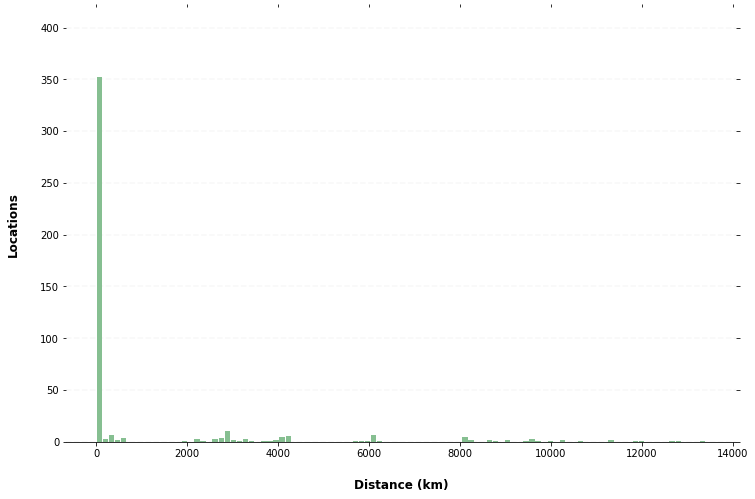

In [44]:
ax = df_FAC_GPE_cleaned.hist(column='distance', bins=100, grid=False, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Distance (km)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Locations", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(StrMethodFormatter('{x:,g}'))

**Exercise**

- Look at the tweets with distance over 1000km. What are the reasons for the big distance?

[Return to Table of Contents](#Table-of-contents)

# Assignment

The class is split into two groups. Each group will have 1 unique task, after which results are shared amoungst the groups and an overal task where both groups discuss on the process of the location extraction and geocoding exercise.  

> *Use the spaCy_labelling notebook for the assignment.*
>
> *spaCy_labelling_guide.pdf contains the labelling instructions for both exercises*

****
**Group 1:**

To get a better understanding of our results, we need to check the accuracy of the model used. Fscore is used to compute model accuracy by computing the confusion matrix (False positive, False negative, True positive, True positive). We label our data for the presence of absence of a location and compare the extracted output against the expected output. Essentially we want to reduce the number of false positive and false negative location extractions (*model accuracy*) and increase the number of true positives and true negative location extractions (*model precision*) .

>- label data for the presence or missing location
>- Compute F-score of the model (recall vs precision)
>- Discuss the reasons for the obtained F-score value and its implications on the study results. Add suggestions on how to increase the F-score?
>-It might be possible that data with location is identified as having a location but the location identified is not the correct location. What do we do with that instance?
****
****
**Group 2:**

For our case study we want to extract locations where a user is and not a place reference from the past or future. With spaCy we have extracted all location mentions within the tweets irrespective of the temporal reference. With GNSS present, we can filter out locations outside say outside 5km radius as referenced locations. However for tweets without GNSS (where we can not apply groung truthing) we need to be able to filter out referenced locations before hand. We label our data with 2 classes user's present location or other.

>- Label time frame of location reference (Present time / other)
>- Compute diplacements for the two groups of lables and discuss the results 
>- To avoid always having to manually label the dataset, discuss stratergies that can be used to split temporal references?  
****
****
**Overal:**

 Share your findings from the individual group exercises. Discuss the presented method used in the notebook to extract and geocode locations:
>- Preprocessing routins 
>- spaCy entity extraction
>- entity combinations 
>- Nominatim geocoding 

How can this approach be improved 


[Return to Table of Contents](#Table-of-contents)

# Possibly useful codes 

In [ ]:
# Defining search area
# By running this line of code before geocoding we restrict the search area to locations within California
# The code then reduces locations like CA from being geocoded to Canada instead of Califonia

#geocode = lambda query: locator.geocode("%s, California, USA" % query, timeout = 30000)

## Grammatical Filtering

In [ ]:
# defining keywords for historial mentions 

"""past_keywords = [travelled to", "Last week", 'last night', 'last Monday', 'last tuesday', 
                  'last wednesday', 'last thursday', 'last friday', 'last saturday', 'last month', 
                 'last year', 'last winter', 'last summer', 'last autumn', 'last days'  "yesterday", 
                 "I was in ", 'were in', 'I was at', "I went", "was at ", 'was in ', 'were at ', 'went to ',
                 "landed from", "passed through", "had visited", 'had gone to', "flew from", 'flew in from',
                 'back from', "throwback", "past years", "miss being in", "I miss ", 'years ago ', 'days ago ',
                 'months ago ', 'hours ago ', 'time ago ', 'was leaving in ', 'was staying at', 'was leaving at',
                 'was staying in', 'makes me miss', 'im from', 'are from ', 'originally from', 'grew up in', 'grew up at ']
"""
#past_searched = '|'.join(past_keywords) # for searching keywords within sentence structures

In [ ]:
# Filtering the data to return only data with the specific keyword
# case = False makes the search case insensitive 
# na = false means we dont return errors when there are unexpected types in series 

df_past = df[df["clean_text"].str.contains(past_searched, case = False, na = False)]
df_past

In [ ]:
# defining keywords for future mentions 
# We add space before and after 'to' to make the text standalone

"""future_keywords = ["going to ",'driving to', "Taking the train to", "taking the car to",
                   "taking the bus on", "headin to",'heading to', 'headed for', "leave for",
                   "leaving for", 'go to', 'travel to', 'trip to','travelling to', 'moving to',
                   'relocating to', 'flying to', "vist ", 'will be going', 'will be at ',
                   'will be in ', 'tomorrow', 'next week', 'next days', 'next Monday',
                   'next Tuesday', 'next Wednesday', 'next Thursday', 'next Friday', 
                   'next Saturday', 'next Sunday', 'tonight at', 'join us for', 'on mondays',
                   'on tuesdays', 'on wednesdays', 'on Thursdays', 'on fridays', 'on saturdays',
                   'on sundays', 'on weekends', 'on weekends', 'weeks from now', 'next stop ',
                   'move to ', 'later on ', 'later this ' ]
""""
#future_searched = '|'.join(future_keywords) # for searching keywords within sentence structures

In [ ]:
# filtering data to return only future mentions 

#df_future = df[df["clean_text"].str.contains(future_searched, case = False, na = False)]
#df_future

[Return to Table of Contents](#Table-of-contents)